<a href="https://colab.research.google.com/github/ghassenSW/dates_classifier/blob/main/dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Packages**

In [ ]:
import os
import math
import numpy as np
import h5py
import scipy
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework import ops
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [ ]:
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [ ]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = "/content/drive/MyDrive/Date_Dataset/Train",
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')

Found 2581 images belonging to 11 classes.
Data Augmentation 1 was used to generate train data set



In [ ]:
test_generator = data_generator_3.flow_from_directory(
    directory = "/content/drive/MyDrive/Date_Dataset/Test",
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 3 was used to generate test data set\n')

Found 368 images belonging to 11 classes.
Data Augmentation 3 was used to generate test data set



In [ ]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Deglet Nour dryer': 0, 'Deglet Nour oily': 1, 'Deglet Nour oily treated': 2, 'Deglet Nour semi-dryer': 3, 'Deglet Nour semi-dryer treated': 4, 'Deglet Nour semi-oily': 5, 'Deglet Nour semi-oily treated': 6, 'alig': 7, 'bessra': 8, 'kenta': 9, 'kintichi': 10}
Class labels: ['Deglet Nour dryer', 'Deglet Nour oily', 'Deglet Nour oily treated', 'Deglet Nour semi-dryer', 'Deglet Nour semi-dryer treated', 'Deglet Nour semi-oily', 'Deglet Nour semi-oily treated', 'alig', 'bessra', 'kenta', 'kintichi']


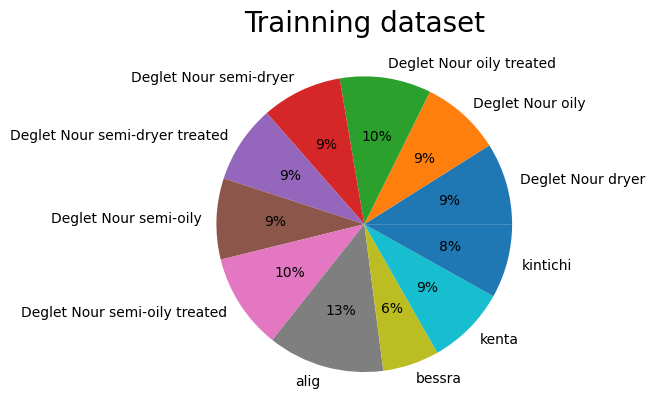

In [ ]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [ ]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:\n")
print("Number of images:", len(train_generator1.classes))
for key,val in dict_class.items():
  print(f"Number of {key}:",len([label for label in train_generator1.classes if label==val]))
print()

# Dataset characteristics
print("Dataset Characteristics of Test Data Set:\n")
print("Number of images:", len(test_generator.classes))
for key,val in dict_class.items():
  print(f"Number of {key}:",len([label for label in test_generator.classes if label==val]))
print()

Dataset Characteristics of Train Data Set:

Number of images: 2581
Number of Deglet Nour dryer: 231
Number of Deglet Nour oily: 225
Number of Deglet Nour oily treated: 258
Number of Deglet Nour semi-dryer: 227
Number of Deglet Nour semi-dryer treated: 220
Number of Deglet Nour semi-oily: 229
Number of Deglet Nour semi-oily treated: 270
Number of alig: 329
Number of bessra: 159
Number of kenta: 224
Number of kintichi: 209

Dataset Characteristics of Test Data Set:

Number of images: 368
Number of Deglet Nour dryer: 33
Number of Deglet Nour oily: 32
Number of Deglet Nour oily treated: 37
Number of Deglet Nour semi-dryer: 33
Number of Deglet Nour semi-dryer treated: 31
Number of Deglet Nour semi-oily: 32
Number of Deglet Nour semi-oily treated: 38
Number of alig: 47
Number of bessra: 23
Number of kenta: 32
Number of kintichi: 30



In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.0157418339236521,
 1: 1.0428282828282829,
 2: 0.9094432699083862,
 3: 1.0336403684421305,
 4: 1.0665289256198347,
 5: 1.0246129416435092,
 6: 0.869023569023569,
 7: 0.7131804365846919,
 8: 1.4757004002287022,
 9: 1.0474837662337662,
 10: 1.122662026968247}

Train image data from Data Augmentation 1


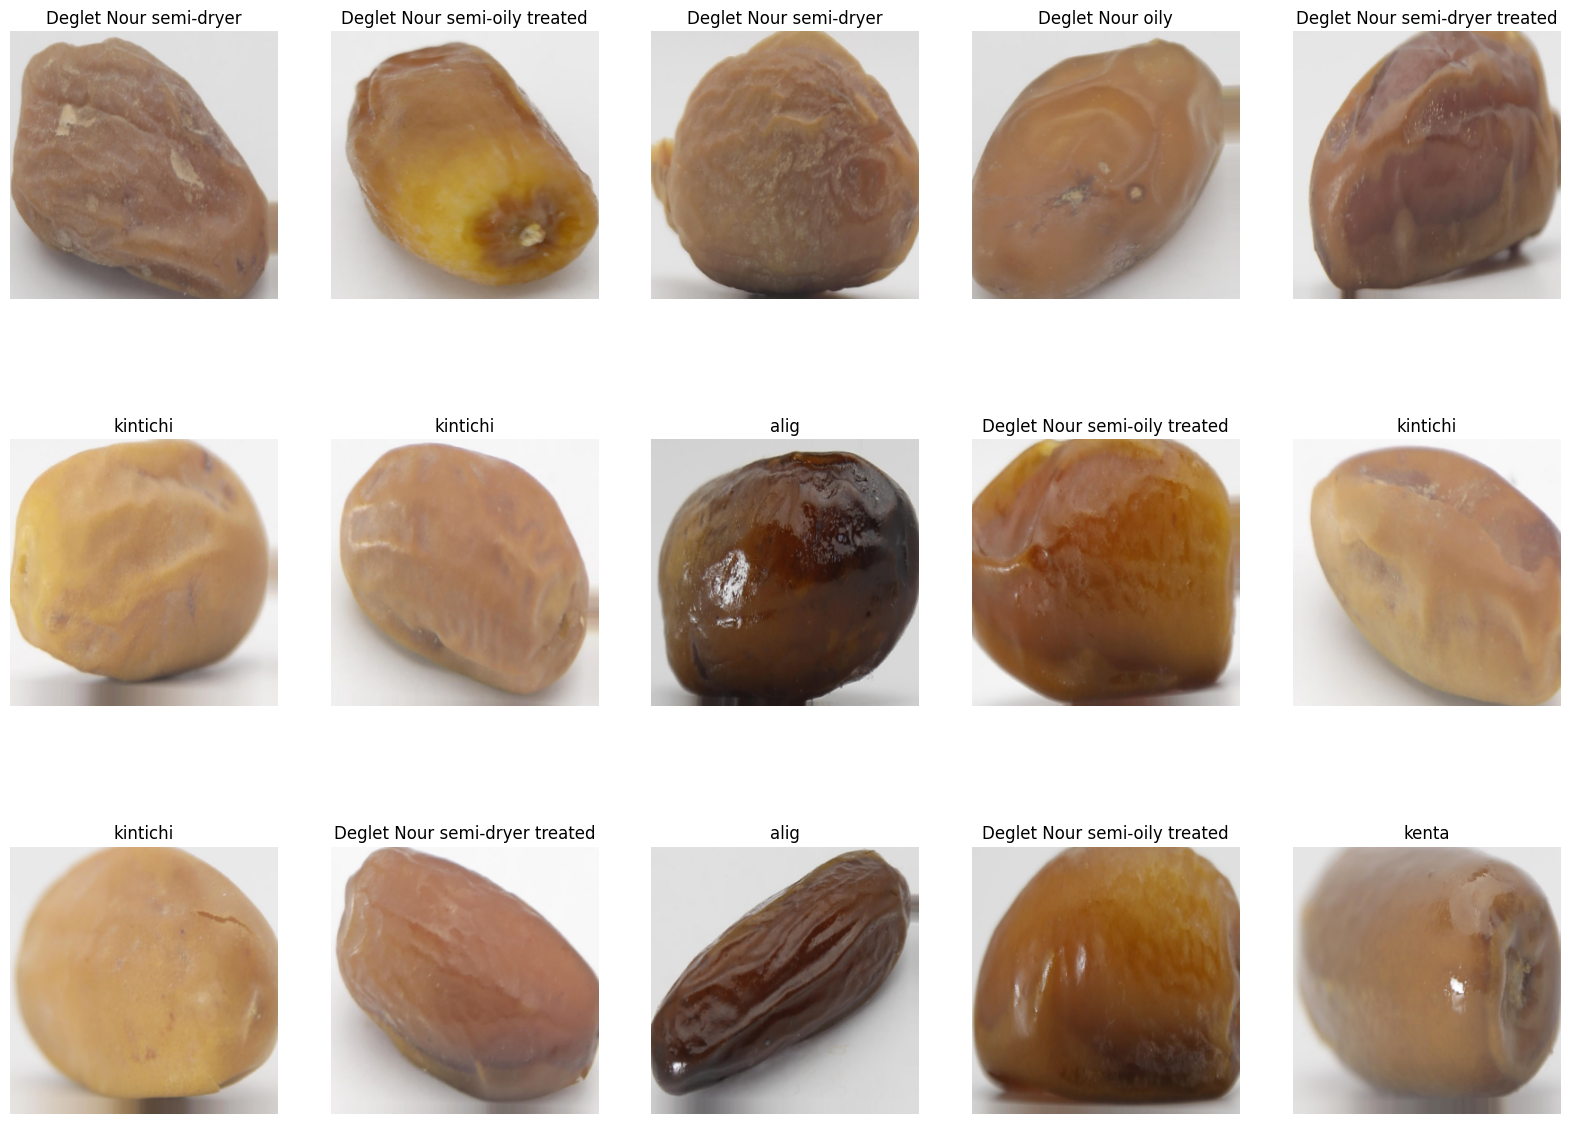

In [ ]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[20, 15])
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [ ]:
# Define the epochs for training
EPOCHS = 10

# Define the number of GPUs to use
num_gpus = 2

# Merge augmented image data for training
# merged_train_generator = chain(train_generator1, train_generator2, train_generator3)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

# For development purpose, we first limit the train data set to the original image data set
# train_data = merged_train_generator
# train_data = train_generator1
train_data = train_generator1
# train_data = test_generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

# Define image height and width
image_height = 224  # Example, adjust to your dataset
image_width = 224   # Example, adjust to your dataset

# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0'])
# Open a strategy scope
with strategy.scope():
    # Use an Input layer to define the input shape explicitly
    model_VGG16 = Sequential()
    model_VGG16.add(Input(shape=(image_height, image_width, 3)))  # Define the input shape here

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False)

    # Add the base model to the new model
    model_VGG16.add(base_model_VGG16)

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(11, activation='softmax'))  # Adjust the number of classes to 4

    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')


Model Summary (VGG16):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,789,323 (56.42 MB)

 Trainable params: 74,635 (291.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Epoch 1/2
54/54 ━━━━━━━━━━━━━━━━━━━━ 4032s 73s/step - accuracy: 0.1165 - loss: 2.6752 - val_accuracy: 0.2092 - val_loss: 2.4458
Epoch 2/2
54/54 ━━━━━━━━━━━━━━━━━━━━ 3857s 71s/step - accuracy: 0.1786 - loss: 2.4108 - val_accuracy: 0.3397 - val_loss: 2.1756
Restoring model weights from the end of the best epoch: 2.
8/8 ━━━━━━━━━━━━━━━━━━━━ 409s 49s/step - accuracy: 0.3477 - loss: 2.1629
Validation Loss: 2.1712
Validation Accuracy: 0.3375


# **Data Augmentation**

In [ ]:
data_dir = "/content/drive/MyDrive/Date_Dataset/Train"
output_dir = "/content/drive/MyDrive/augmented_Date_Dataset/Train"
os.makedirs(output_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    for image_name in os.listdir(class_path):
        img_path = os.path.join(class_path, image_name)
        if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        from tensorflow.keras.preprocessing.image import load_img, img_to_array
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        count = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_output_path,
                                  save_prefix="aug", save_format="jpeg"):
            count += 1
            if count >= 3:
                break


KeyboardInterrupt: 

# **Data Normalization & Preparation**

In [ ]:
def load_images_and_labels(data_dir, target_size=(64, 64)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            try:
                img = Image.open(file_path).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    return np.array(images), np.array(labels), class_names


In [ ]:
train_set_x_orig,train_set_y_orig,class_names=load_images_and_labels('/content/drive/MyDrive/augmented_Date_Dataset/Train')
test_set_x_orig,test_set_y_orig,class_names=load_images_and_labels('/content/drive/MyDrive/augmented_Date_Dataset/Test')
val_set_x_orig,val_set_y_orig,class_names=load_images_and_labels('/content/drive/MyDrive/augmented_Date_Dataset/Validation')

In [ ]:
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
val_set_y_orig=val_set_y_orig.reshape((1,val_set_y_orig.shape[0]))

In [ ]:
X_train = train_set_x_orig.astype('float32')/255
X_test = test_set_x_orig.astype('float32')/255
X_val = val_set_x_orig.astype('float32')/255

In [ ]:
Y_train = np.eye(11)[train_set_y_orig.reshape(-1)]
Y_test = np.eye(11)[test_set_y_orig.reshape(-1)]
Y_val = np.eye(11)[val_set_y_orig.reshape(-1)]

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape)

(7487, 64, 64, 3) (7487, 11)
(1102, 64, 64, 3) (1102, 11)
(2195, 64, 64, 3) (2195, 11)


# **Data Visualisation**

y = Deglet Nour dryer


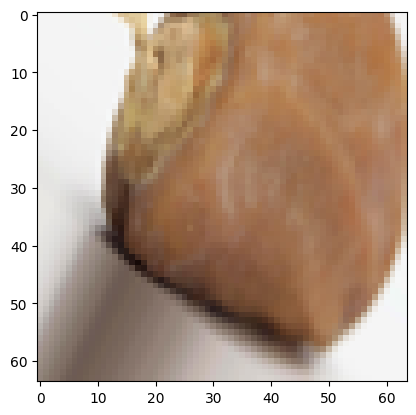

In [ ]:
# Example of a picture
index = 400
plt.imshow(X_train[index])
print ("y = " + class_names[np.argmax(Y_train[index])])

# **Creating the CNN Model**

In [ ]:
def create_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='softmax'))

    return model

In [ ]:
# Create the model
model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.load_weights('model_checkpoint (1).h5')


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,043 (1.22 MB)

 Trainable params: 320,043 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# **Training the Model**

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=16,
    verbose=1
    )

test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

model.save('model_checkpoint.h5')


Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.9069 - loss: 0.2498 - val_accuracy: 0.8856 - val_loss: 0.3175
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.9120 - loss: 0.2351 - val_accuracy: 0.8966 - val_loss: 0.2835
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9166 - loss: 0.2266 - val_accuracy: 0.8975 - val_loss: 0.2785
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.9227 - loss: 0.2068 - val_accuracy: 0.8993 - val_loss: 0.2799
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.9213 - loss: 0.2225 - val_accuracy: 0.8911 - val_loss: 0.2938
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.9190 - loss: 0.2236 - val_accuracy: 0.8916 - val_loss: 0.3008
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.9186 - loss: 0.2188 - val_accuracy: 0.8934 - val_loss: 0.2899
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.9159 - loss: 0.2235 - 

Test Accuracy: 0.88


In [ ]:
model.save('model_checkpoint.h5')


In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

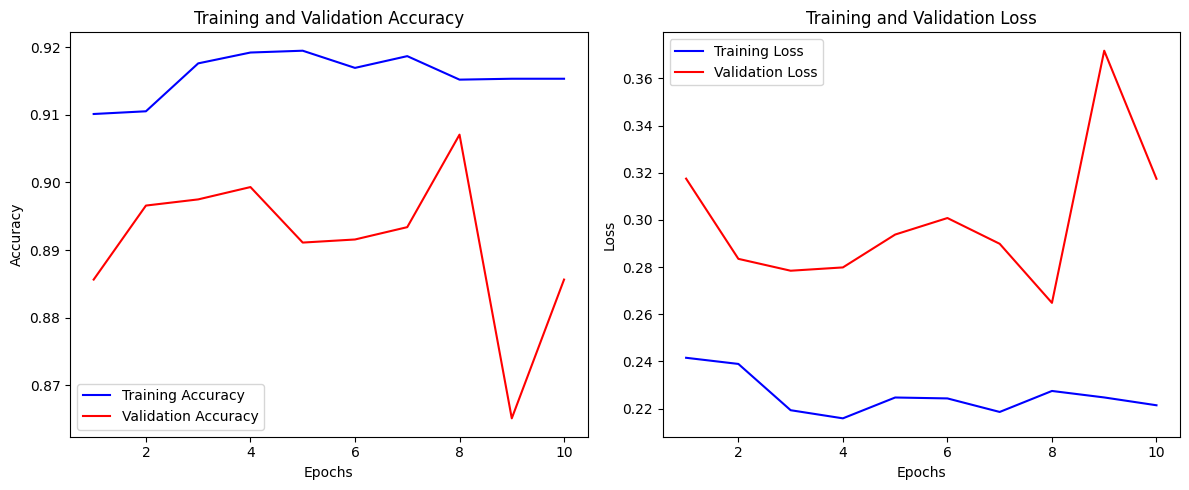

In [ ]:
plot_training_history(history)